In [1]:
#                       _oo0oo_
#                      o8888888o
#                      88" . "88
#                      (| -_- |)
#                      0\  =  /0
#                    ___/`---'\___
#                  .' \\|     |# '.
#                 / \\|||  :  |||# \
#                / _||||| -:- |||||- \
#               |   | \\\  -  #/ |   |
#               | \_|  ''\---/''  |_/ |
#               \  .-\__  '-'  ___/-. /
#             ___'. .'  /--.--\  `. .'___
#          ."" '<  `.___\_<|>_/___.' >' "".
#         | | :  `- \`.;`\ _ /`;.`/ - ` : | |
#         \  \ `_.   \_ __\ /__ _/   .-` /  /
#     =====`-.____`.___ \_____/___.-`___.-'=====
#                       `=---='
#
#
#     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
#               佛祖保佑         永无BUG

In [197]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'

In [796]:
import pandas as pd
import numpy as np
import implicit
import matplotlib.pyplot as plt
import lightgbm as lgb

from implicit.nearest_neighbours import bm25_weight
from scipy.sparse import csr_matrix
from implicit.evaluation import train_test_split, ndcg_at_k, precision_at_k
from sklearn.neighbors import BallTree
from tqdm import tqdm
from collections import defaultdict
import time
from joblib import Parallel as JoblibParallel, delayed
from sklearn.metrics import auc, roc_auc_score

from dateutil.relativedelta import relativedelta

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [681]:
def get_millis_time():
    return int(time.time() * 1000)


def format_time(interval):
    interval = relativedelta(microseconds=(interval * 10 ** 6))
    amounts = interval.days, interval.hours, interval.minutes, interval.seconds, interval.microseconds / 10 ** 3
    result = ' '.join(
        u'{} {}'.format(int(amount), label)
        for amount, label in zip(amounts, ['d', 'h', 'm', 's', 'ms']) if amount
    )
    if not result:
        result = u'0 ms'
    return result


class TimeLatch(object):
    def __init__(self):
        self._start_time = time.time()

    def took(self):
        start_time = self._start_time
        self._start_time = time.time()  # finish time
        return self._start_time - start_time

    def current(self):
        return time.time() - self._start_time

    def took_msg(self):
        return format_time(self.took())

In [821]:
class Parallel(JoblibParallel):
    def __call__(self, iterable):
        if self.n_jobs == 1:
            return [function(*args, **kwargs) for function, args, kwargs in iterable]
        else:
            return super(Parallel, self).__call__(iterable)

def partition_indices(total, part, nparts):
    if not (0 <= part < nparts):
        raise ValueError()
    part_size = total // nparts
    left = total % nparts
    lower = part_size * part + min(left, part)
    return lower, lower + part_size + (1 if part < left else 0)        
        
def partition(array, nparts):
    return [
        array[left_index:right_index]
        for left_index, right_index in (partition_indices(len(array), part, nparts) for part in range(nparts))
    ]

def _group(group_sizes, *arrays):
    left_index = 0
    for group_size in group_sizes:
        yield [array[left_index:left_index + group_size] for array in arrays]
        left_index += group_size
        
def get_serp_sizes(serp_values):
    serp_values = np.array(serp_values)
    serp_values = serp_values.flatten()
    _, serp_value_idx = np.unique(serp_values, return_index=True)
    return np.diff(np.sort(np.concatenate([serp_value_idx, np.array([len(serp_values)])])))

def _compute_single_ndcg(y_true, y_pred, cut_off=10):
    if cut_off is None:
        cut_off = len(y_true)

    if np.unique(y_true).size == 1:
        return np.nan

    actual = (y_true[np.argsort(-y_pred)])[:cut_off]
    ideal = np.sort(y_true)[::-1][:cut_off]

    size = actual.shape[0]
    denominator = np.log2(np.arange(size) + 2)
    dcg = ((2 ** actual - 1) / denominator).sum()
    idcg = ((2 ** ideal - 1) / denominator).sum()
    return dcg / idcg

def _compute_ndcg(y_true, y_pred, groups, cut_off=10, mean=True):
    ndcg = np.array([
        _compute_single_ndcg(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ndcg) if mean else ndcg

def _compute_single_mauc(y_true, y_pred):
    if np.unique(y_true).size == 1:
        return np.nan

    return roc_auc_score(y_true, y_pred)

def _compute_mauc(y_true, y_pred, groups, _, mean=True):
    mauc = np.array([
        _compute_single_mauc(group_target, group_pred)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(mauc) if mean else mauc

def _compute_ap(y_true, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    truth = (y_true[order] > 0.0).astype(float)

    positive = sum(truth)
    if positive == 0.0 or positive == len(truth):
        return np.nan

    cut_off_ = cut_off if cut_off is not None else len(truth)

    denominator = min(cut_off_, positive)
    truth.resize(cut_off_)
    return np.divide(np.multiply(truth, np.cumsum(truth)), 1.0 + np.arange(cut_off_)).sum() / denominator

def _compute_map(y_true, y_pred, groups, cut_off=10, mean=True):
    ap = np.array([
        _compute_ap(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ap) if mean else ap

def _compute_single_recall(y_true, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    truth = (y_true[order] > 0.0).astype(float)

    positive = sum(truth)
    if positive == 0.0 or positive == len(truth):
        return np.nan

    cut_off_ = cut_off if cut_off is not None else len(truth)

    denominator = min(cut_off_, positive)
    truth.resize(cut_off_)
    return 1. * truth[:cut_off_].sum() / denominator

def _compute_recall(y_true, y_pred, groups, cut_off=10, mean=True):
    ap = np.array([
        _compute_single_recall(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ap) if mean else ap    


def _prepare_diversity_entities_group(entity, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    cut_off_ = cut_off if cut_off is not None else len(entity)
    return entity[order][:cut_off]

def _prepare_diversity_entities(entity, y_pred, groups, cut_off=10, mean=True):
    result = [
        _prepare_diversity_entities_group(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, entity, y_pred)
    ]
    return np.hstack(result)  
    
def _compute_ranking_metric(metric_computer, y_true, y_pred, groups, cut_off, mean, ncores):
    groups_parts = partition(groups, ncores)
    metrics = Parallel(n_jobs=ncores)(
        delayed(metric_computer)(y_true_part, y_pred_part, groups_part, cut_off, mean=False)
        for (y_true_part, y_pred_part), groups_part in zip(_group(map(sum, groups_parts), y_true, y_pred), groups_parts)
    )
    metrics = np.hstack(metrics)
    return np.nanmean(metrics) if mean else metrics


def compute_map(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_map, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_ndcg(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_ndcg, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_mauc(y_true, y_pred, groups, ncores, cut_off=None, mean=True):
    return _compute_ranking_metric(_compute_mauc, y_true, y_pred, groups, None, mean, ncores)


def compute_recall(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_recall, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_entropy_diversity(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    entities = _compute_ranking_metric(_prepare_diversity_entities, y_true, y_pred, groups, cut_off, False, ncores)
    counts = pd.DataFrame(entities).value_counts().values
    counts = counts / len(entities)
    return (-counts * np.log(counts)).sum()


def compute_coverage(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    entities = _compute_ranking_metric(_prepare_diversity_entities, y_true, y_pred, groups, cut_off, False, ncores)
    return len(set(entities))


class Metric(object):
    def __init__(self, name, target='target', pred='pred', group='customer_id', ncores=1):
        self.name = name
        self.target = target
        self.pred = pred
        self.group = group
        self.ncores = ncores

    def compute_score(self, target, prediction, ncores, group=None):
        raise NotImplementedError()
        
    def __call__(self, df):
        pred = df[self.pred]
        target = df[self.target]
        group = df.groupby(self.group).target.count().values
        return self.compute_score(target, pred, self.ncores, group)
        
class RankingCutoffMetric(Metric):
    def __init__(self, name, computer, cut_off=None):
        if cut_off is not None:
            name = '{}@{}'.format(name, cut_off)
        super().__init__(name)
        self.cut_off = cut_off
        self.computer = computer

    def compute_score(self, target, prediction, ncores, group=None):
        if group is None:
            raise ValueError('group must be provided for {}'.format(self.name))
        target = np.array(target)
        prediction = np.array(prediction)
        return self.computer(target, prediction, group, ncores, self.cut_off)
    

class MapMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('map', compute_map, cut_off)


class NdcgMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('ndcg', compute_ndcg, cut_off)


class MeanAucMetric(RankingCutoffMetric):
    def __init__(self):
        super().__init__('mauc', compute_mauc)
        
class RecallMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('recall', compute_recall, cut_off)
        
class EntropyDiversityMetric(RankingCutoffMetric):
    def __init__(self, entity, cut_off=None):
        super().__init__(f'entropy_diversity_of_{entity}', compute_entropy_diversity, cut_off)
        self.ncores = 36
        self.target = entity
        
class CoverageMetric(RankingCutoffMetric):
    def __init__(self, entity, cut_off=None):
        super().__init__(f'coverage_of_{entity}', compute_coverage, cut_off)
        self.ncores = 36
        self.target = entity
        
METRICS = [MeanAucMetric()]
for k in (1, 5, 15):
    METRICS += [NdcgMetric(k), RecallMetric(k),
                EntropyDiversityMetric('chain_id', k), EntropyDiversityMetric('default_product_group_id', k),
                CoverageMetric('chain_id', k), CoverageMetric('default_product_group_id', k)]

In [664]:
df = pd.read_csv('data_made_restaurants.csv', )

In [665]:
df.drop(columns=['Unnamed: 0'], inplace=True)

# remove customer_id = -10 - as unknown customer
df = df[df['customer_id'] != -10].reset_index(drop=True)

# remove product_group_ids is None - not a restaurants, they are food markets
market_index = pd.isnull(df.product_group_ids)
df = df[~df['product_group_ids'].isnull()].reset_index(drop=True)

In [666]:
# need to remove fastfood from validation
fastfood = {
    'Макдоналдс': df[df['chain_name'] == 'Макдоналдс']['chain_id'].unique().tolist(),
    'KFC': df[df['chain_name'] == 'KFC']['chain_id'].unique().tolist(),
    'Burger King': df[df['chain_name'] == 'Burger King']['chain_id'].unique().tolist(),
}

fastfoold_chains = np.hstack([chain_id for chain_id in fastfood.values()])

In [667]:
df = df[~df.chain_id.isin(fastfoold_chains)]

In [668]:
# add date features
df['date'] = pd.to_datetime(df['date'])
df['week'] = (df['date'] - df['date'].min()).dt.days // 7
df['day_of_week'] = df['date'].dt.dayofweek

In [669]:
customer_ids = df.groupby('customer_id').chain_id.nunique()
customer_ids = np.array(customer_ids[customer_ids > 1].index)
df = df[df.customer_id.isin(customer_ids)]

In [670]:
df = df.reset_index(drop=True)

In [679]:
def most_frequent_default_product_group_id(df):
    counter = defaultdict(int)
    largest = np.nan
    result = []
    for _, row in df.iterrows():
        result.append(largest)
        product_id = row['default_product_group_id']
        counter[product_id] += 1
        if np.isnan(largest) or counter[product_id] > counter[largest]:
            largest = product_id        
    return np.array(result)
    
def _compute_historical_feature(feature_computer, df, groups):
    values = [
        feature_computer(group[0]) for group in _group(groups, df)
    ]
    return np.hstack(values)

def compute_historical_feature(feature_computer, df, ncores):   
    groups = get_serp_sizes(df['customer_id'])
    groups_parts = partition(groups, ncores)
    features = Parallel(n_jobs=ncores)(
        delayed(_compute_historical_feature)(feature_computer, df_part[0], groups_part)
        for df_part, groups_part in zip(_group(map(sum, groups_parts), df), groups_parts)
    )    
    return np.hstack(features)

In [684]:
NCORES = 36

HIST_FEATURES = {
    'most_frequent_default_product_group_id': most_frequent_default_product_group_id
}

df = df.sort_values(['customer_id', 'date'], inplace=True)

for name, func in HIST_FEATURES.items():
    latch = TimeLatch()
    df[name] = compute_historical_feature(func, df, NCORES)
    print(f'computed {name}, {latch.took_msg()}')
    
df.sort_index(inplace=True)

computed most_frequent_default_product_group_id, 15 s 467 ms


In [689]:
# split data on order, customer and vendor entities
pairs = df[['order_id', 'customer_id', 'vendor_id', 'chain_id', 'city_id', 'target',
            'total_value', 'discount_value', 'delivery_fee', 'user_latitude', 'user_longitude',
            'date', 'week', 'day_of_week'] + list(HIST_FEATURES.keys())]

vendor_data = (df[['vendor_id', 'chain_id', 'chain_name', 'ddk_flag',
                  'vendor_latitude', 'vendor_longitude', 'online_payment', 'accepting_cash',
                  'min_delivery_value', 'takeaway_support', 'citymobil_support',
                  'default_product_group_id', 'product_group_ids', 'cuisine_ids', 'city_id']]
               .drop_duplicates().reset_index(drop=True))

# identify user coordinates by the most frequent (or the last) order
customer_data = pairs.groupby(['customer_id', 'user_latitude', 'user_longitude'])['vendor_id'].count().reset_index()
customer_data = customer_data.merge(
    pairs.groupby(['customer_id', 'user_latitude', 'user_longitude'])['date'].max().reset_index())
customer_data.sort_values(by=['customer_id', 'vendor_id', 'date'], inplace=True, ascending=False)
customer_data = customer_data.groupby('customer_id')[['user_latitude', 'user_longitude']].first().reset_index()

### Validation

In [674]:
def split_by_folds(df):
    # split data on train and validation
    folds = {
        'previous': df[df['week'] <= 3].index.tolist(),
        'test': df[df['week'] >= 11].index.tolist()
    }
    
    for fold_num, week in enumerate(range(4, 7)):
        fold_train = df[(df['week'] >= week) & (df['week'] < (week + 4))]
        folds[f'train_{fold_num + 1}'] = fold_train.index.tolist()
        
        fold_val = df[(df['week'] == (week + 4)) 
                      & (~df['chain_id'].isin(fastfoold_chains))] # remove fastfood from validation
        
        # remove train orders from validation
        tmp = fold_train[['customer_id', 'chain_id']].drop_duplicates()
        tmp['is_in_train'] = 1
        fold_val = fold_val.merge(tmp, how='left')
        fold_val = fold_val[fold_val['is_in_train'].isnull()].reset_index(drop=True)
        
        folds[f'val_{fold_num + 1}'] = fold_val.index.tolist()
        
    return folds

In [283]:
def build_vendor_tree(df):
    # bulld data structure for fast geo search
    vendor_coords = df[['vendor_id', 'vendor_latitude', 'vendor_longitude']].drop_duplicates()
    
    tree = BallTree(np.radians(vendor_coords[['vendor_latitude', 'vendor_longitude']]), 
                    leaf_size=40, metric='haversine')
    
    return tree, vendor_coords

In [701]:
def sample_zeros(tree, user_coords, vendor_coords, radius=5000, n_samples=50):
    # sample zeros as vendor_ids within some radius
    R = 6367000
    ind, dist = tree.query_radius(np.radians(user_coords[['user_latitude', 'user_longitude']]), 
                                  r=radius/R, return_distance=True)
    
    zeros = []
    vendor_coords_values = vendor_coords['vendor_id'].values
    
    for i, customer_id in enumerate(user_coords['customer_id']):
        vendors = ind[i]
        if n_samples:
            vendors = np.random.choice(ind[i], size=min(len(vendors), n_samples), replace=False)
        zeros += [(customer_id, vendor, 0) for vendor in vendor_coords_values[vendors]]
        
    return pd.DataFrame(zeros, columns=['customer_id', 'vendor_id', 'target'])

In [285]:
def add_zeros_to_folds(fold, pairs_zeros):
    
    fold = pd.concat([fold, pairs_zeros[pairs_zeros['customer_id'].isin(fold['customer_id'])]], axis=0)
    fold.drop_duplicates(subset=['customer_id', 'chain_id', 'target'], inplace=True)
    fold = (fold.groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
            .merge(fold))
    return fold

In [676]:
tree, vendor_coords = build_vendor_tree(vendor_data)

In [702]:
pairs_zeros_train = sample_zeros(tree, customer_data, vendor_coords)
pairs_zeros_val = sample_zeros(tree, customer_data, vendor_coords, n_samples=None)

In [703]:
# add source features to sampled zeros
pairs_zeros_train = (pairs_zeros_train
               .merge(customer_data)
               .merge(vendor_data[['vendor_id', 'chain_id']].drop_duplicates()))

pairs_zeros_val = (pairs_zeros_val
               .merge(customer_data)
               .merge(vendor_data[['vendor_id', 'chain_id']].drop_duplicates()))

In [692]:
folds = split_by_folds(pairs)

In [693]:
folds.keys()

dict_keys(['previous', 'test', 'train_1', 'val_1', 'train_2', 'val_2', 'train_3', 'val_3'])

In [704]:
pairs_zeros_train.shape

(8593390, 6)

### Feature engineering

In [292]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367000 * c
    return km

In [762]:
def create_features(pairs, vendor_data):
    # add source features
    pairs = pairs.merge(vendor_data, on=['chain_id', 'vendor_id'])
    
    # add crafted features
    pairs['distance'] = haversine(pairs['user_latitude'], pairs['user_longitude'],
                                  pairs['vendor_latitude'], pairs['vendor_longitude'])
    
    for name in HIST_FEATURES.keys():
#         values = pairs[pairs.target == 1].groupby('customer_id')[name].apply(np.array)
#         for customer_id in tqdm(values.index):
#             idx = (pairs.target == 0) & (pairs.customer_id == customer_id)
#             pairs.loc[idx, name] = np.random.choice(values[customer_id], (idx > 0).sum(), replace=True)
        pairs.sort_values(by=['customer_id', 'target', 'date'], ascending=[True, False, True], inplace=True)
        na = pairs[name].fillna(method='ffill')
        index = (pairs.target == 0)
        pairs.loc[index, name] = na[index]
    
    # sort data for lambdamart
    pairs.sort_values(by=['customer_id', 'chain_id', 'target'], inplace=True)
    return pairs

In [831]:
feats = [
    # source features
    'user_latitude', 'user_longitude',
    'vendor_latitude', 'vendor_longitude', 
    'min_delivery_value', 
    'ddk_flag', 'online_payment', 'accepting_cash', 
    'takeaway_support', 'citymobil_support', 
    'most_frequent_default_product_group_id',
    'default_product_group_id',
    'city_id_y', 'chain_id',
    
    # crafted features
    'distance'
]

### Train

In [758]:
def prepare_fold(pairs, pairs_zeros, distance=5000):
    pairs = add_zeros_to_folds(pairs, pairs_zeros)
    pairs = create_features(pairs, vendor_data)
    pairs = pairs[pairs.distance < distance]
    pairs = pairs[pairs.groupby('customer_id').target.transform('sum') > 0]
    return pairs

In [763]:
# validate on fold 1
tr1 = prepare_fold(pairs.loc[folds['train_1']], pairs_zeros_train)
val1 = prepare_fold(pairs.loc[folds['val_1']], pairs_zeros_val)

In [775]:
val1 = val1[~val1.customer_id.isin(val1[pd.isnull(val1[list(HIST_FEATURES.keys())[0]])].customer_id.unique())]

In [776]:
val1.shape

(3226807, 29)

In [824]:
lgb_params = {
    'num_boost_round': 400,
#     'early_stopping_round': 20,
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [15],
    'verbosity': 1,
#     'max_position': 15,
    'lambdamart_norm': True,
    'eta': 0.1,
    'max_depth': 6,
    'min_data_in_leaf': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 1,
    'seed': 42,
    'nthread': 36
}

In [832]:
dtrain = lgb.Dataset(tr1[feats], label=tr1['target'],
                     group=tr1.groupby('customer_id')['target'].count().values)
dval = lgb.Dataset(val1[feats], label=val1['target'],
               group=val1.groupby('customer_id')['target'].count().values)

In [833]:
evals_res = {}
model = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dval], evals_result=evals_res, verbose_eval=100)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 4557276, number of used features: 15
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[100]	training's ndcg@15: 0.728864	valid_1's ndcg@15: 0.383304
[200]	training's ndcg

In [836]:
# complete randomness
val1['pred'] = np.random.rand(val1.shape[0])
for metric in METRICS:
    print(f'{metric.name}: {metric(val1)}')

mauc: 0.49965379024882545
ndcg@1: 0.007681684791990333
recall@1: 0.007681684791990333
entropy_diversity_of_chain_id@1: 8.125544312362173
entropy_diversity_of_default_product_group_id@1: 2.9294920918298626
coverage_of_chain_id@1: 4991
coverage_of_default_product_group_id@1: 37
ndcg@5: 0.023162581347652235
recall@5: 0.03914206801311928
entropy_diversity_of_chain_id@5: 8.439924513646707
entropy_diversity_of_default_product_group_id@5: 2.9337727167414123
coverage_of_chain_id@5: 8438
coverage_of_default_product_group_id@5: 37
ndcg@15: 0.045657383353602886
recall@15: 0.11486564244202772
entropy_diversity_of_chain_id@15: 8.499628332636984
entropy_diversity_of_default_product_group_id@15: 2.933268994090375
coverage_of_chain_id@15: 9661
coverage_of_default_product_group_id@15: 37


In [822]:
# model on few features 
val1['pred'] = model.predict(val1[feats])
for metric in METRICS:
    print(f'{metric.name}: {metric(val1)}')

mauc: 0.7708057643885756
ndcg@1: 0.03089936129811842
recall@1: 0.03089936129811842
entropy_diversity_of_chain_id@1: 7.216100590804242
entropy_diversity_of_default_product_group_id@1: 2.448640884156321
coverage_of_chain_id@1: 2971
coverage_of_default_product_group_id@1: 33
ndcg@5: 0.07705810398299431
recall@5: 0.12484895563611255
entropy_diversity_of_chain_id@5: 7.773228395173657
entropy_diversity_of_default_product_group_id@5: 2.5211323674407855
coverage_of_chain_id@5: 6392
coverage_of_default_product_group_id@5: 37
ndcg@15: 0.132127408224723
recall@15: 0.30811611715288567
entropy_diversity_of_chain_id@15: 8.003333819402826
entropy_diversity_of_default_product_group_id@15: 2.554696093717503
coverage_of_chain_id@15: 8619
coverage_of_default_product_group_id@15: 37


In [827]:
# model on many features
val1['pred'] = model.predict(val1[feats])
for metric in METRICS:
    print(f'{metric.name}: {metric(val1)}')

mauc: 0.9086201775673162
ndcg@1: 0.17089590885551528
recall@1: 0.17089590885551528
entropy_diversity_of_chain_id@1: 5.551464645626543
entropy_diversity_of_default_product_group_id@1: 2.41654588265862
coverage_of_chain_id@1: 1642
coverage_of_default_product_group_id@1: 34
ndcg@5: 0.3011328034625642
recall@5: 0.42272282639967773
entropy_diversity_of_chain_id@5: 6.70013922846556
entropy_diversity_of_default_product_group_id@5: 2.5953356967995487
coverage_of_chain_id@5: 4713
coverage_of_default_product_group_id@5: 35
ndcg@15: 0.3724170035298551
recall@15: 0.6546118879106968
entropy_diversity_of_chain_id@15: 7.443272435625005
entropy_diversity_of_default_product_group_id@15: 2.671402459078822
coverage_of_chain_id@15: 7588
coverage_of_default_product_group_id@15: 36


In [835]:
#overfitted model on chain_id
val1['pred'] = model.predict(val1[feats])
for metric in METRICS:
    print(f'{metric.name}: {metric(val1)}')

mauc: 0.9337782730210241
ndcg@1: 0.26929052304505435
recall@1: 0.26929052304505435
entropy_diversity_of_chain_id@1: 4.869499451634534
entropy_diversity_of_default_product_group_id@1: 2.3722293984960734
coverage_of_chain_id@1: 1183
coverage_of_default_product_group_id@1: 34
ndcg@5: 0.4094216320994021
recall@5: 0.5350998331319409
entropy_diversity_of_chain_id@5: 6.246805981489375
entropy_diversity_of_default_product_group_id@5: 2.60458435230788
coverage_of_chain_id@5: 3702
coverage_of_default_product_group_id@5: 36
ndcg@15: 0.47646012702032203
recall@15: 0.7542004718338223
entropy_diversity_of_chain_id@15: 7.166213901753197
entropy_diversity_of_default_product_group_id@15: 2.6938464238974955
coverage_of_chain_id@15: 6551
coverage_of_default_product_group_id@15: 36


In [790]:
val1.sort_values(['target', 'pred'], ascending=False).head(30)

,customer_id,chain_id,target,order_id,vendor_id,city_id_x,total_value,discount_value,delivery_fee,user_latitude,user_longitude,date,week,day_of_week,most_frequent_default_product_group_id,chain_name,ddk_flag,vendor_latitude,vendor_longitude,online_payment,accepting_cash,min_delivery_value,takeaway_support,citymobil_support,default_product_group_id,product_group_ids,cuisine_ids,city_id_y,distance,pred
6648955,15507651,118750,1,212473227.0,247366,24.0,1239.0,137.0,0.0,43.5968,39.7320,2020-08-14,1.0,4.0,2.0,Гиро,0,43.596814,39.732036,1,1,800,1,0,2.0,"[1, 2, 32, 36]",NaN,24,3.288490,3.239643
6648974,50470496,118750,1,232995103.0,247366,24.0,1085.0,191.0,0.0,43.5968,39.7320,2020-10-04,9.0,6.0,2.0,Гиро,0,43.596814,39.732036,1,1,800,1,0,2.0,"[1, 2, 32, 36]",NaN,24,3.288490,3.239643
5472809,63578273,120446,1,240423776.0,253900,1.0,1055.0,263.0,0.0,55.9256,37.8630,2020-10-21,11.0,2.0,5.0,PIZZASUSHIWOK,0,55.930509,37.859372,1,1,600,0,0,1.0,"[1, 2, 18, 51]",NaN,156,590.423186,2.811958
6078732,3322974,36618,1,232795238.0,87868,7.0,685.0,0.0,0.0,55.0339,82.8917,2020-10-04,9.0,6.0,33.0,Сибирский Гриль,0,55.035730,82.896184,1,1,600,0,0,29.0,"[1, 2, 6, 29]",[5],7,350.567200,2.811697
6078766,14966606,36618,1,233189101.0,87868,7.0,690.0,0.0,0.0,55.0337,82.9029,2020-10-04,9.0,6.0,37.0,Сибирский Гриль,0,55.035730,82.896184,1,1,600,0,0,29.0,"[1, 2, 6, 29]",[5],7,483.543700,2.780383
3735784,16606800,9218,1,225037358.0,26764,1.0,908.0,353.0,0.0,55.8906,37.6658,2020-09-15,6.0,1.0,33.0,TacoLand,0,55.888104,37.662452,1,1,950,0,0,35.0,"[26, 29, 35]",[5],1,347.079719,2.637465
5472959,86076596,120446,1,229153755.0,253900,1.0,1174.0,0.0,0.0,55.9225,37.8421,2020-09-25,7.0,4.0,6.0,PIZZASUSHIWOK,0,55.930509,37.859372,1,1,600,0,0,1.0,"[1, 2, 18, 51]",NaN,156,1395.863107,2.612348
6460942,65432041,56050,1,243127054.0,261184,9.0,1107.0,330.0,0.0,55.7707,49.1789,2020-10-26,12.0,0.0,37.0,2 Берега,0,55.769054,49.189005,1,1,500,0,0,1.0,"[1, 2, 18, 26]","[1, 2, 3, 5]",9,657.612523,2.404708
1746233,11756292,9218,1,233508988.0,81886,1.0,1237.0,595.0,0.0,55.7325,37.4419,2020-10-05,9.0,0.0,36.0,TacoLand,0,55.730938,37.441754,1,1,950,0,0,35.0,"[26, 29, 35]",[5],1,173.817658,2.373570
1746072,3286715,9218,1,234757924.0,81886,1.0,612.0,359.0,0.0,55.7302,37.4301,2020-10-09,9.0,4.0,36.0,TacoLand,0,55.730938,37.441754,1,1,950,0,0,35.0,"[26, 29, 35]",[5],1,733.821729,2.373454


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

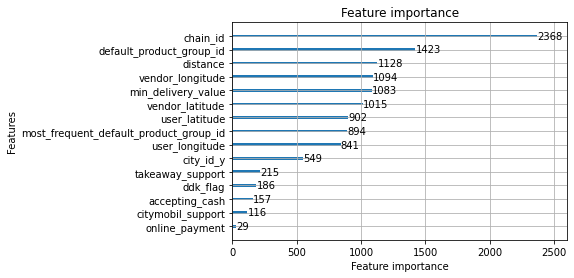

In [834]:
lgb.plot_importance(model)

In [795]:
NdcgMetric(15).compute_score(val1['target'], val1['pred'], 1, val1.groupby('customer_id').target.count().values)

0.132127408224723

In [ ]:
CoverageMetric(15)

### ALS

In [41]:
params = {
    'n_components': 100,
    'bm25_params': {
        'K1': 100,
        'B': 0.8,
    },
    'seed': 42,
    'scale': 100,
    'num_threads': 2,
    'num_iter': 10,
    'regularization': 1
}

def create_item_user_matrix(df, params):
    data = df[['customer_id', 'chain_id', 'target']].copy()
    
    unique_rows = list(np.unique(data['customer_id']).astype(np.int32))
    unique_cols = list(np.unique(data['chain_id']).astype(np.int32))

    row_map = dict(zip(unique_rows, range(len(unique_rows))))
    col_map = dict(zip(unique_cols, range(len(unique_cols))))

    data['customer_id'] = data['customer_id'].map(row_map)
    data['chain_id'] = data['chain_id'].map(col_map)

    matrix = csr_matrix((data['target'], [data['customer_id'], data['chain_id']]))
    matrix = bm25_weight(matrix, **params['bm25_params']).T.tocsr() * params['scale']
    
    return matrix

def compute_als_decomposition(matrix, params):
    np.random.seed(params['seed'])
    implicit_als = implicit.als.AlternatingLeastSquares(
        params['n_components'], num_threads=params['num_threads'], iterations=params['num_iter'],
        regularization=params['regularization']
    )
    implicit_als.fit(matrix)

    return implicit_als

In [42]:
previous_fold = pairs.loc[folds['previous']].groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
prev_matrix = create_item_user_matrix(previous_fold, params)

train_m, val_m = train_test_split(prev_matrix, 0.7)

In [43]:
implicit_als = compute_als_decomposition(train_m, params)

In [44]:
precision_at_k(implicit_als, train_m.T, val_m.T, K=15)

0.07463876586266673

In [45]:
ndcg_at_k(implicit_als, train_m.T, val_m.T)

0.044341897295772356

In [10]:
import node2vec
import numpy as np
import networkx as nx

In [22]:
tr1 = pairs.loc[folds['train_1']].copy()

In [27]:
tr1[tr1.groupby(['customer_id']).chain_id.transform('nunique') > 1]

,order_id,customer_id,vendor_id,chain_id,city_id,target,total_value,discount_value,delivery_fee,user_latitude,user_longitude,date,week,day_of_week
259,218193562,48258998,343852,140718,1,1,785,0,0,55.7880,37.4613,2020-08-29,4,5
260,218197283,61552413,343852,140718,1,1,805,0,0,55.8346,37.6596,2020-08-29,4,5
262,218269492,66605061,343852,140718,1,1,1155,0,0,55.8531,37.6834,2020-08-29,4,5
263,218356630,4420697,343852,140718,1,1,2079,0,0,55.8439,37.5541,2020-08-29,4,5
264,218372344,292437,343852,140718,1,1,684,76,0,55.6936,37.5777,2020-08-29,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535102,229325669,6934383,454558,190270,2,1,513,111,69,59.9002,30.5207,2020-09-25,7,4
2535108,229335026,90394710,253222,120746,2,1,2840,0,0,59.9350,30.2442,2020-09-25,7,4
2535119,229345473,66354859,305728,32022,1,1,675,225,0,55.7235,37.8105,2020-09-25,7,4
2535132,229366616,6845038,453340,135226,2,1,693,156,69,59.9618,30.3300,2020-09-25,7,4
